### Try-it 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models.  You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model.  In addition to the prior strategies, this example is an excellent opportunity to utilize the `TransformedTargetRegressor` estimator in scikitlearn.

### The Data

This dataset is loaded from the openml resource library.  Originally from census data, the data contains wage and demographic information on 534 individuals. From the dataset documentation [here](https://www.openml.org/d/534)

```
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. 
```

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
wages = fetch_openml(data_id=534, as_frame=True)

/home/elmunoz42/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
wages.frame.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


#### Task

Build regression models to predict `WAGE`.  Incorporate the categorical features and transform the target using a logarithm.  Build `Ridge` models and consider some different amounts of regularization.  

After fitting your model, interpret the model and try to understand what features led to higher wages.  Consider using `permutation_importance` that you encountered in module 8.  Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients see the example in scikitlearn examples [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
import numpy as np
import plotly.express as px
import pandas as pd
import warnings

In [25]:
df = wages.frame
categorical_features = ['SEX', 'SOUTH', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the categorical features
encoded_features = encoder.fit_transform(df[categorical_features])

# Convert the encoded features to a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Combine the encoded features with the original DataFrame (excluding the original categorical columns)
df_encoded = pd.concat([df.drop(columns=categorical_features), encoded_df], axis=1)
X = df_encoded.drop('WAGE', axis = 1)

# Make WAGE_log column to present the wage data in base 10 logarithmic scale
wage = df_encoded['WAGE']

wage_log = np.log10(wage)

# Add the transformed column back to the DataFrame
df_encoded['WAGE_log'] = wage_log

y = df_encoded['WAGE_log']

print(X)
print(y)

     EDUCATION  EXPERIENCE  AGE  SEX_female  SEX_male  SOUTH_no  SOUTH_yes  \
0            8          21   35         1.0       0.0       1.0        0.0   
1            9          42   57         1.0       0.0       1.0        0.0   
2           12           1   19         0.0       1.0       1.0        0.0   
3           12           4   22         0.0       1.0       1.0        0.0   
4           12          17   35         0.0       1.0       1.0        0.0   
..         ...         ...  ...         ...       ...       ...        ...   
529         18           5   29         0.0       1.0       1.0        0.0   
530         12          33   51         1.0       0.0       1.0        0.0   
531         17          25   48         1.0       0.0       1.0        0.0   
532         12          13   31         0.0       1.0       0.0        1.0   
533         16          33   55         0.0       1.0       1.0        0.0   

     UNION_member  UNION_not_member  RACE_Hispanic  ...  \
0   

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [39]:
# Ridge Regression Model Pipeline with GridSearchCV used to find best alpha value
pipe_1 = Pipeline([
    ('scale', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
    ('ridge', Ridge())
])
param_dict = {'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000, 1000000]}
grid_1 = GridSearchCV(estimator=pipe_1, param_grid=param_dict).fit(X_train, y_train)
best_model = grid_1.best_estimator_
model_1_train_mse = mean_squared_error(y_train, best_model.predict(X_train))
model_1_test_mse = mean_squared_error(y_test, best_model.predict(X_test))
model_1_best_alpha =grid_1.best_params_
# Get the best alpha
model_1_best_alpha = grid_1.best_params_['ridge__alpha']

# get coefficients
# Assuming best_model is your best estimator from the grid search
ridge_model = best_model.named_steps['ridge']

# Get the coefficients from the Ridge model
model_1_coeffs = ridge_model.coef_

# Assuming feature_names is a list of your feature names
feature_names = best_model.named_steps['poly_features'].get_feature_names_out(input_features=X_train.columns)

# Create a DataFrame to display the coefficients against the features
coeff_df = pd.DataFrame({'Feature': feature_names, 'Ridge Coefficient': model_1_coeffs})

# Optionally, sort the DataFrame by the absolute value of the coefficients
coeff_df_sorted = coeff_df.sort_values(by='Ridge Coefficient', ascending=False)

print(coeff_df_sorted)
print(f'model_1_train_mse: {model_1_train_mse}')
print(f'model_1_test_mse: {model_1_test_mse}')
print(f'Best alpha: {model_1_best_alpha}')

                                  Feature  Ridge Coefficient
2479            OCCUPATION_Professional^3           0.002091
520     EDUCATION OCCUPATION_Management^2           0.002016
2379              OCCUPATION_Management^3           0.001993
539   EDUCATION OCCUPATION_Professional^2           0.001706
299                           EDUCATION^3           0.001651
...                                   ...                ...
1784      UNION_member^2 UNION_not_member          -0.001290
591       EXPERIENCE^2 OCCUPATION_Service          -0.001366
612     EXPERIENCE AGE OCCUPATION_Service          -0.001389
843              AGE^2 OCCUPATION_Service          -0.001446
2543                 OCCUPATION_Service^3          -0.002655

[2599 rows x 2 columns]
model_1_train_mse: 0.02709343110310612
model_1_test_mse: 0.03798365133304225
Best alpha: 10000.0


In [40]:
# Define the pipeline with TransformedTargetRegressor
pipe_2 = Pipeline([
    ('scale', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
    ('ridge', TransformedTargetRegressor(
        regressor=Ridge(),
        func=np.log1p,  # Apply log transformation to the target
        inverse_func=np.expm1  # Apply exponential transformation to the predictions
    ))
])

# Define the parameter grid
param_dict_2 = {'ridge__regressor__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000, 1000000]}

# Perform grid search
grid_2 = GridSearchCV(estimator=pipe_2, param_grid=param_dict_2).fit(X_train, y_train)

# Get the best model
best_model_2 = grid_2.best_estimator_

# Calculate mean squared errors
model_2_train_mse = mean_squared_error(y_train, best_model_2.predict(X_train))
model_2_test_mse = mean_squared_error(y_test, best_model_2.predict(X_test))

# Get the best alpha
model_2_best_alpha = grid_2.best_params_['ridge__regressor__alpha']

# Access the Ridge model within the pipeline
ridge_model_2 = best_model_2.named_steps['ridge'].regressor_

# Get the coefficients from the Ridge model
model_2_coeffs = ridge_model_2.coef_

# Assuming feature_names is a list of your feature names
feature_names = best_model_2.named_steps['poly_features'].get_feature_names_out(input_features=X_train.columns)

# Create a DataFrame to display the coefficients against the features
coeff_df_2 = pd.DataFrame({'Feature': feature_names, 'Ridge Coefficient': model_2_coeffs})

# Optionally, sort the DataFrame by the absolute value of the coefficients
coeff_df_2_sorted = coeff_df_2.sort_values(by='Ridge Coefficient', ascending=False)

print(coeff_df_2_sorted)
print(f'model_2_train_mse: {model_2_train_mse}')
print(f'model_2_test_mse: {model_2_test_mse}')
print(f'Best alpha: {model_2_best_alpha}')

                                  Feature  Ridge Coefficient
2479            OCCUPATION_Professional^3           0.001115
520     EDUCATION OCCUPATION_Management^2           0.001078
2379              OCCUPATION_Management^3           0.000919
539   EDUCATION OCCUPATION_Professional^2           0.000877
299                           EDUCATION^3           0.000852
...                                   ...                ...
1919                   UNION_not_member^3          -0.000694
591       EXPERIENCE^2 OCCUPATION_Service          -0.000781
612     EXPERIENCE AGE OCCUPATION_Service          -0.000793
843              AGE^2 OCCUPATION_Service          -0.000823
2543                 OCCUPATION_Service^3          -0.001459

[2599 rows x 2 columns]
model_2_train_mse: 0.027237295132530905
model_2_test_mse: 0.038419177919679824
Best alpha: 10000.0


/home/elmunoz42/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


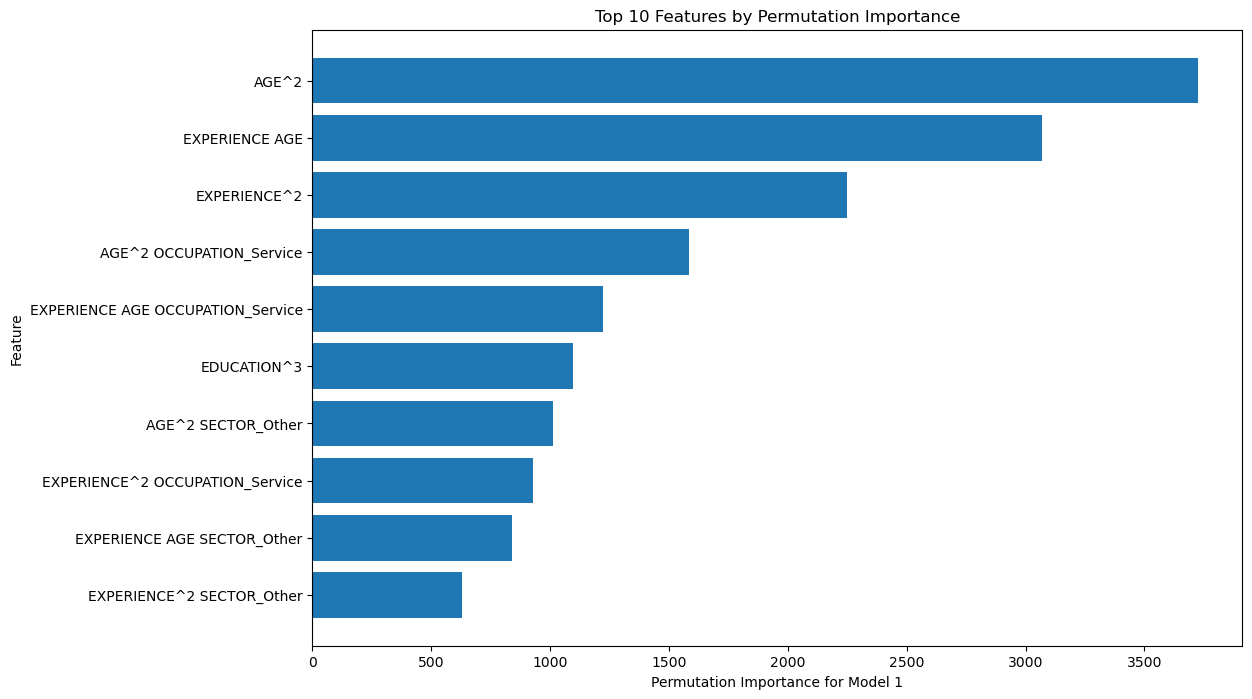

In [53]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Extract the PolynomialFeatures step from the pipeline
poly_features = best_model.named_steps['poly_features']

# Transform X_test using the pipeline
X_test_transformed = best_model.named_steps['poly_features'].transform(X_test)

# Calculate permutation importance on the transformed X_test
perm_importance_1 = permutation_importance(best_model.named_steps['ridge'], X_test_transformed, y_test, n_repeats=10, random_state=42)

# Ensure feature_names matches the number of features in X_test
feature_names = best_model.named_steps['poly_features'].get_feature_names_out(input_features=X_test.columns)

# Create a DataFrame for permutation importance
perm_df = pd.DataFrame({'Feature': feature_names, 'Importance': perm_importance_1.importances_mean})

# Sort the DataFrame by importance
perm_df_sorted = perm_df.sort_values(by='Importance', ascending=False)

# Select the top ten features
top_10_features = perm_df_sorted.head(10)

# Plot the permutation importance for the top ten features
plt.figure(figsize=(12, 8))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Permutation Importance for Model 1')
plt.ylabel('Feature')
plt.title('Top 10 Features by Permutation Importance')
plt.gca().invert_yaxis()
plt.show()
